# 3. Dealing with Missing Values <a class="anchor"  id="chapter3"></a>
It looks like there are some missing values in the Age, Fare, Cabin, and Embarked columns. Note that the missing values in the Survived category are just from the test data set, which doesn't contain the output variable. I will deal with the missing values for the other columns below.

## 3.1 Missing values for 'Fare': <a class="anchor"  id="section_3_1"></a>

There is only 1 missing value for the 'Fare_per_passenger' feature. I will impute it using other features that are available to us for that instance and in the dataset.

In [16]:
# Looks like the observation that has'Fare_per_passenger' missing is for a passenger 
# that belonged to Pclass == 3 and was traveling alone
display(combined[combined['Fare_per_passenger'].isna()])

# As we saw earlier, families in the same Pclass paid a similar fare per passenger
display(combined.groupby('Pclass')['Fare_per_passenger'].describe())

# Find index for that observation
index = combined[combined['Fare_per_passenger'].isna()].index

# Impute'Fare_per_passenger' with mean of the 'Fare_per_passenger' column values for 'Pclass' equal to 3
combined.loc[index, 'Fare_per_passenger'] = combined[combined['Pclass'] == 3]['Fare_per_passenger'].mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size,Party_size,Is_alone,Fare_per_passenger,Age_cat
1043,1044,NaN,3,male,60.5,0,0,NaN,S,Mr.,0.0,0.0,0.0,1,1,1,1,NaN,3.0


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,33.910500,15.369762,0.0,26.550000,29.70,38.64375,128.0823
2,277.0,11.411010,2.632930,0.0,10.500000,12.35,13.00000,16.0000
3,708.0,7.329146,1.471362,0.0,7.060031,7.75,7.92500,19.9667


## 3.2 Missing values for 'Embarked': <a class="anchor"  id="section_3_2"></a>

It looks like the only two missing values for 'Embarked' are for two women who were staying in the same cabin, B28. Their names were Icard, Miss. Amelie and Stone, Mrs. George Nelson (Martha Evelyn). A quick google search revealed that "*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*" I will impute these missing values with 'S' for Southampton.

*Source: Encyclopedia Titanica*

In [17]:
# What were the names of the passengers with missing 'Embarked' values? 
display(combined[combined['Embarked'].isna()])

# Impute missing values for 'Embarked' with 'S' for Southampton
index = combined[combined['Embarked'].isna()].index
combined.loc[index, 'Embarked'] = 'S'

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size,Party_size,Is_alone,Fare_per_passenger,Age_cat
61,62,1.0,1,female,38.0,0,0,B28,NaN,Miss.,0.0,0.0,0.0,1,2,2,0,40.0,2.0
829,830,1.0,1,female,62.0,0,0,B28,NaN,Mrs.,0.0,0.0,0.0,1,2,2,0,40.0,3.0


## 3.3 Missing values for 'Cabin': <a class="anchor"  id="section_3_3"></a>

There are 1014 missing observations in the 'Cabin' column. The information about the cabin each passenger was staying in would probably be extremely helpful if the data was complete. The cabin could indicate each passenger's location at the time of the collision, which happened at 11:40pm when most people would likely be in bed in their rooms. The location could further inform us as to each passenger's escape route, distance from the initial impact, and how far they were from the stern, which sank first.

I found some interesting information online saying the following: "*The allocation of cabins on the Titanic is a source of continuing interest and endless speculation. Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward Herbert Cave.*" 

What this indicates is that the cabin data that is available to us is mostly for first class passengers. We know that first class passengers were on decks A-E, although decks D and E were also shared with second class. Let's confirm below whether most of the information we have is for first class passengers. 


In [18]:
combined['Deck'] = combined['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else None)

# What proportion of each deck were first class? 
display(combined.groupby('Pclass')['Deck'].count())
display(combined['Pclass'].value_counts())


Pclass
1    256
2     23
3     16
Name: Deck, dtype: int64

3    709
1    323
2    277
Name: Pclass, dtype: int64

We have cabin data for 295 passengers. Here's how that breaks down between passenger classes: 
- 256 are first class
- 23 are second class
- 16 are third class

In other words: 
- 79.26% of first class passengers have cabin data
- 8.30% of second class passengers have cabin data
- 2.26% of third class passengers have cabin data

While cabin data would be very valuable for this analysis, it underrepresents passengers in the second and third classes, and for this reason I decided to drop it altogether. I also considered creating a binary variable that indicates the presence or absence of cabin data for each passenger, but because there appears to be variety of ways the information was sourced (first class passenger list found with Herbert Cave, survivor accounts, and recovered bodies), I don't think its presence or absence will tell us anything particularly useful about a passenger's survival.

In [19]:
combined = combined.drop(columns=['Deck', 'Cabin'])

## 3.4 Missing values for 'Age': <a class="anchor"  id="section_3_4"></a>

While I could just impute the missing values for Age with the median age, I think I could do better by using the other features available in the dataset to take a more educated prediction. 

'Age_cat' is now a categorical variable, which means I will want to use ML algorithms that make categorical predictions, such as the following:
- Random Forest Classifier: an ensemble learning model that combines multiple decision trees to create a more accurate model, randomly selects a subset of features for each tree to prevent overfitting and improve accuracy 
- K-Nearest Neighbors: predicts categorical outcome by based on k-closest neighbors in the training set 
- Support Vector Machines (SVMs): a model that finds the best hyperplane to separate the data into different classes, and then predicts the target variable based on the position of the test point relative to the hyperplane
- Gradient Boosting Classifier: ensemble model that combines multiple weak learners, normally decision trees, to create a strong learned for classification problems 
- Decision Tree Classifier: tree-like model that splits data based on the feature that maximizes information gain or reduces impurity at each node 

I will test these models below, and then pick one to predict and impute the missing ages in the dataset.

In [20]:
# Import necessary libraries for building models
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

# Using get_dummies to create dummy variables for categorical features, dropping first category to avoid multicollinearity
combined_with_dummies = pd.get_dummies(combined, columns=['Title', 'Sex', 'Pclass', 'Embarked'], prefix=['Title', 'Sex', 'Pclass', 'Embarked'], drop_first=True)
combined = pd.concat([combined[['Title', 'Sex', 'Pclass', 'Embarked']], combined_with_dummies], axis=1)
display(combined.columns)

Index(['Title', 'Sex', 'Pclass', 'Embarked', 'PassengerId', 'Survived', 'Age',
       'SibSp', 'Parch', 'In_WCG', 'WCG_not_survived', 'WCG_survived',
       'Family_size', 'Ticket_group_size', 'Party_size', 'Is_alone',
       'Fare_per_passenger', 'Age_cat', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

Note that through some trial and error, I have decided to leave some features out of the below model for predicting 'Age_cat', as well as the final model for predicting 'Survived'. The decision to leave certain features out came down to a combination of the following:

1) The features ranked low on the feature importance graphs, and
2) Avoiding multi-collinearity in the model

Some models, such as Logistic Regression and SVM are more sensitive to multi-collinearity than others, such as Random Forests and Gradient Boosting. In general, eliminating multi-collinearity in model features should improve performance, which is what I saw in my models as well. 

To that end, I will eliminate the following features 
* 'Family_size': directly correlated with 'SibSp' and 'Parch'
* 'Ticket_group_size': directly correlated with 'Party_size' for those that were not traveling with family 

In [21]:
# Splitting combined dataset based on 'Age' missingness
test_age = combined[combined['Age_cat'].isna()]
train_age = combined[combined['Age_cat'].notnull()]

# Selecting numerical and dummy categorical features to include in model 
X = train_age[[
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Fare_per_passenger', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
y = train_age[['Age_cat']].values.ravel()

# Splitting X and y further into training and test sets to test model accuracy 
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.2, random_state=41)

# Scaling the 'Fare_per_passenger' column 
scaler = StandardScaler()

X_train_num_age = X_train_age.loc[:, ['Fare_per_passenger']]
X_test_num_age = X_test_age.loc[:, ['Fare_per_passenger']]

X_train_cat_age = X_train_age.loc[:, [
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
X_test_cat_age = X_test_age.loc[:, [
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]

X_train_num_scaled = scaler.fit_transform(X_train_num_age)
X_test_num_scaled = scaler.transform(X_test_num_age)

# Concatenate scaled numerical and categorical columns
X_train_scaled = np.concatenate([X_train_num_scaled, X_train_cat_age], axis=1)
X_test_scaled = np.concatenate([X_test_num_scaled, X_test_cat_age], axis=1)

Random Forest Regressor Mean Cross-Validation Accuracy Score: 0.5108069575135443
Gradient Boosting Classifier Mean Cross-Validation Accuracy Score: 0.5418520102651839
Support Vector Classifier Mean Cross-Validation Accuracy Score: 0.543056743655546
K-Neighbors Classifier Mean Cross-Validation Accuracy Score: 0.5083618477331051
Decision Tree Classifier Mean Cross-Validation Accuracy Score: 0.4940832620473339
Bagging Mean Cross-Validation Accuracy Score: 0.4988451668092386


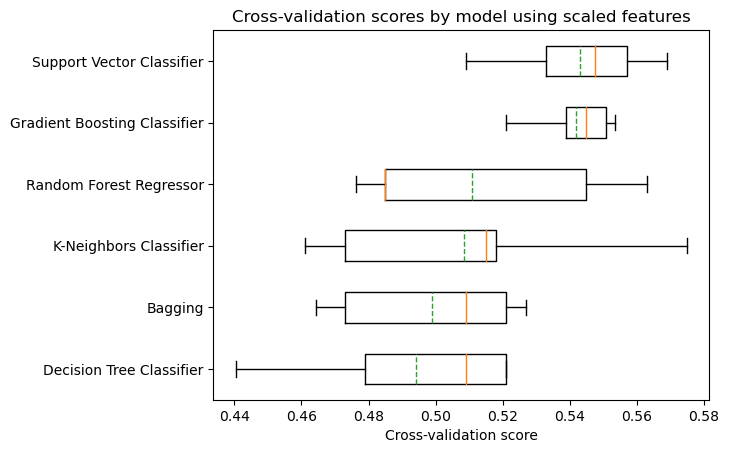

In [22]:
# Testing multiple models using cross validation
np.random.seed(41)
models ={"Random Forest Regressor": RandomForestClassifier(random_state=41), "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=41),
         "Support Vector Classifier": SVC(random_state=41), "K-Neighbors Classifier": KNeighborsClassifier(), 
         "Decision Tree Classifier": DecisionTreeClassifier(random_state=41), "Bagging": BaggingClassifier(random_state=41)}

results = []
for name, model in models.items():
	kf = KFold(n_splits=5, random_state=41, shuffle=True)
	cv_results = cross_val_score(model, X_train_scaled, y_train_age, cv=kf) 
	results.append(cv_results)
	print("{} Mean Cross-Validation Accuracy Score: {}".format(name, cv_results.mean()))
    
# Sort the models by the mean cross-validation accuracy score
sorted_results = sorted(zip(models.keys(), results), key=lambda x: x[1].mean(), reverse=False)
labels = [model[0] for model in sorted_results]
results = [model[1] for model in sorted_results]

plt.boxplot(results, labels=labels, meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model using scaled features')
plt.xlabel('Cross-validation score')
plt.show()

It looks like none of my models are particularly accurate. Gradient Boosting Classifier creates the best model, at an accuracy score of just 54.19%. Let's take a look at the accuracy scores and confusion matrices for the test set.

RandomForestClassifier(random_state=41) Accuracy Score on Test Set: 0.5523809523809524


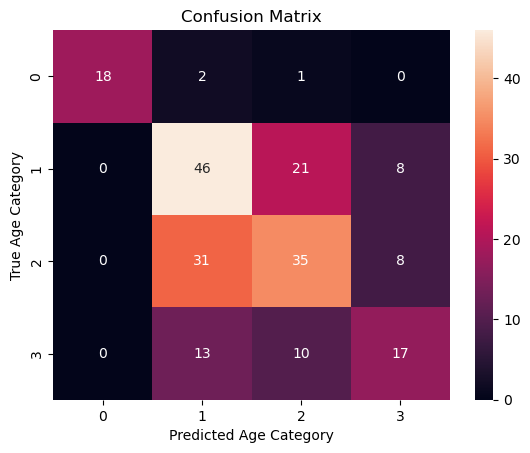

GradientBoostingClassifier(random_state=41) Accuracy Score on Test Set: 0.5714285714285714


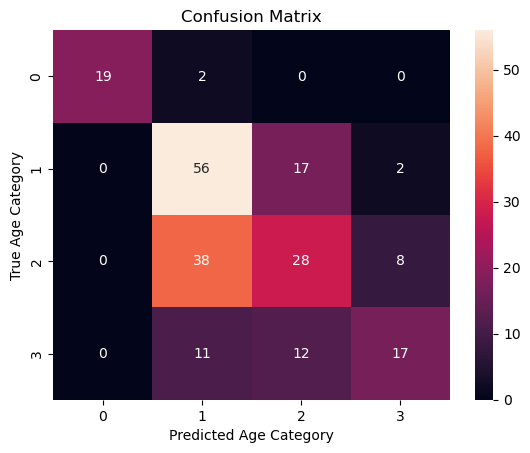

SVC(random_state=41) Accuracy Score on Test Set: 0.6


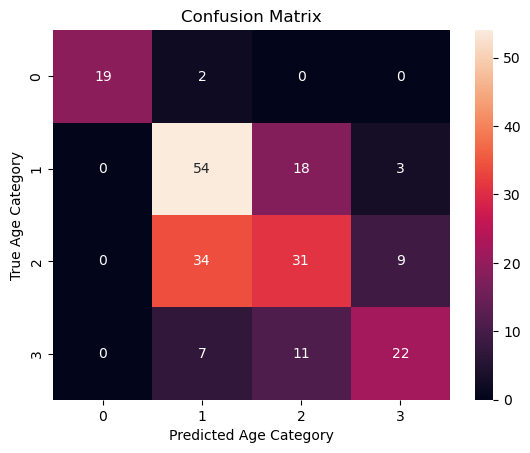

KNeighborsClassifier() Accuracy Score on Test Set: 0.47619047619047616


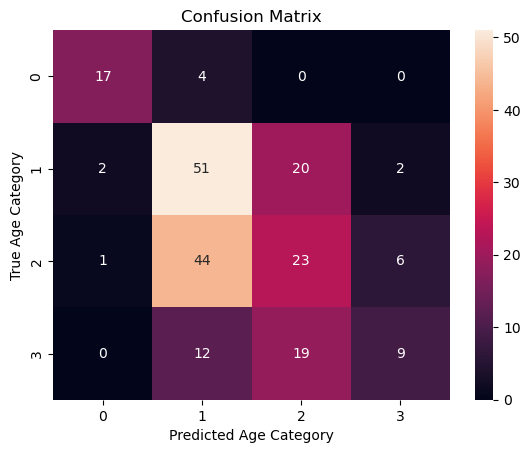

DecisionTreeClassifier(random_state=41) Accuracy Score on Test Set: 0.5190476190476191


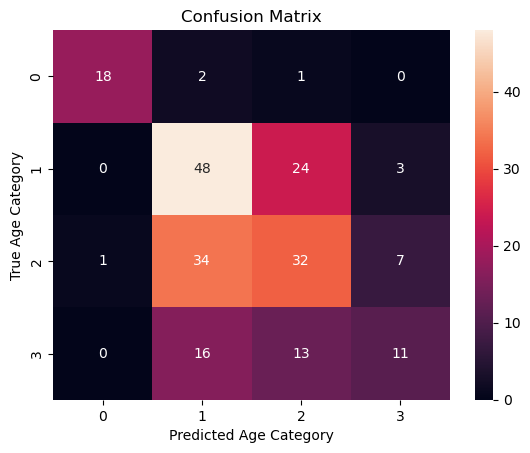

BaggingClassifier(random_state=41) Accuracy Score on Test Set: 0.5285714285714286


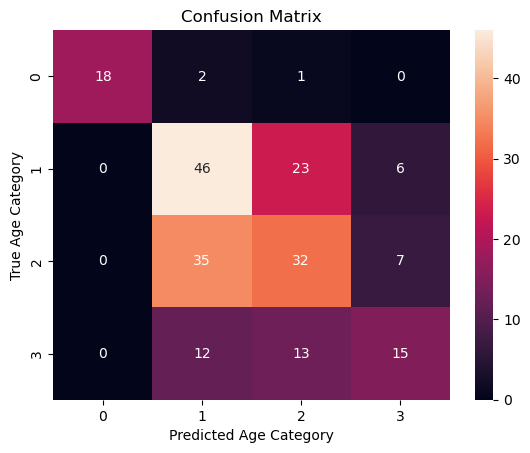

In [23]:
# Testing multiple models on test set, visualizing predictions
results = []
for model in models.values():
    # Fit model on training data, predict test set accuracy
	model.fit(X_train_scaled, y_train_age)
	y_pred_age = model.predict(X_test_scaled)
	accuracy_score = model.score(X_test_scaled, y_test_age)
	print("{} Accuracy Score on Test Set: {}".format(model, accuracy_score))
    
    # Plotting confusion matrix
	cm = confusion_matrix(y_test_age, y_pred_age)
	sns.heatmap(cm, annot=True, fmt='d')
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted Age Category')
	plt.ylabel('True Age Category')
	plt.show()

Even though the accuracy scores for the models are not very impressive, the models do seem to be pretty good at predicting age categories for children ('Age_cat' == 0) and teenagers ('Age_cat' ==1). For example, in the Gradient Boosting Classifier model, the model correctly predicted 19 children out of 21 in the test set 90.48%), and 56 out of 76 teenagers in the test set (73.68%). Note that before, we saw how children have the highest survival rate, while teenagers have the lowest. Given the model's accuracy for the most important age categories, I will impute missing values using the Gradient Boosting Classifier model, which has the best mean cross-validation accuracy score. 

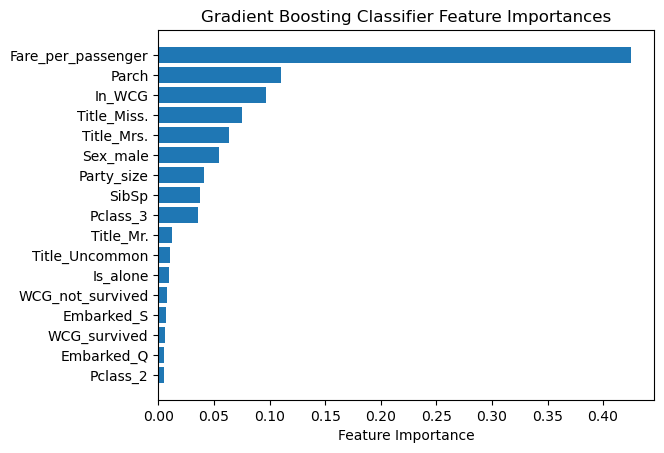

In [24]:
# Fitting GBC on training data
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled, y_train_age)

# Extracting and plotting feature importances
feature_importances = gbc.feature_importances_
feature_names = np.array(['Fare_per_passenger', 'SibSp', 'Parch',  
       'In_WCG','WCG_not_survived', 'WCG_survived', 'Party_size', 
       'Is_alone', 'Title_Miss.', 'Title_Mr.', 
       'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S'])

# Sort coefficients in descending order
sort_index = np.argsort(feature_importances)
sorted_coefs = feature_importances[sort_index]
sorted_feature_names = feature_names[sort_index]

plt.barh(sorted_feature_names, sorted_coefs)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Classifier Feature Importances')
plt.show()

Above, I have plotted the feature importances for the Gradient Boosting Classifier model. Note that this graph does not specify the direction of the relationship between a feature and the outcome variable, 'Age_cat'; only the relative importance. It looks like the most important features in predicting age category are 'Fare_per_passenger', 'Parch', and 'In_WCG'.

In [25]:
# Preparing to impute missing age categories
X_train_cat_age_final = X.loc[:, [
       'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
X_test_cat_age_final = test_age.loc[:, [
       'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]

X_train_num_age_final  = X.loc[:, ['Fare_per_passenger']]
X_test_num_age_final = test_age.loc[:, ['Fare_per_passenger']]

scaler = StandardScaler()

X_train_num_age_scaled_final = scaler.fit_transform(X_train_num_age_final)
X_test_num_age_scaled_final = scaler.transform(X_test_num_age_final)

# Concatenate scaled numerical and categorical columns
X_train_scaled_final = np.concatenate([X_train_num_age_scaled_final, X_train_num_age_final], axis=1)
X_test_scaled_final = np.concatenate([X_test_num_age_scaled_final, X_test_num_age_final], axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


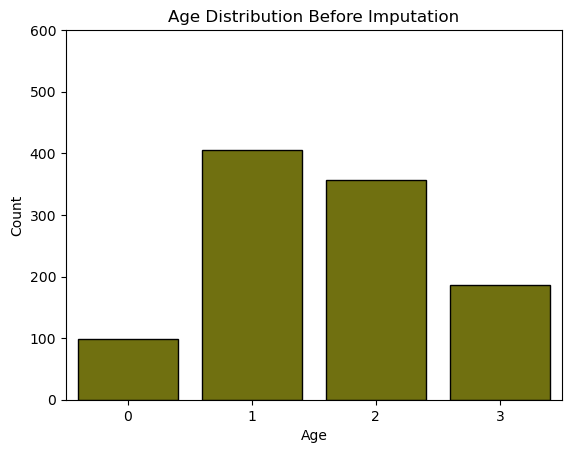

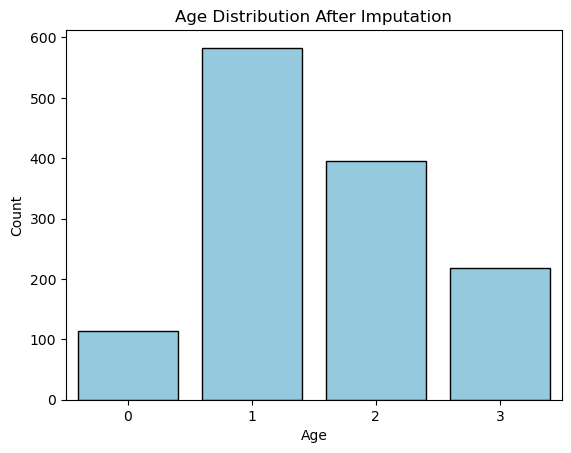

,Pclass,PassengerId,Survived,Age,SibSp,Parch,In_WCG,WCG_not_survived,WCG_survived,Family_size,...,Age_cat,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Uncommon,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
count,1309.000000,1309.000000,891.000000,1046.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,655.000000,0.383838,29.881138,0.498854,0.385027,0.200917,0.072574,0.128342,1.883881,...,1.548510,0.201681,0.578304,0.151261,0.022154,0.644003,0.211612,0.541635,0.093965,0.699771
std,0.837836,378.020061,0.486592,14.413493,1.041658,0.865560,0.400839,0.259536,0.334598,1.583639,...,0.868304,0.401408,0.494019,0.358440,0.147242,0.478997,0.408607,0.498454,0.291891,0.458533
min,1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,328.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,655.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,3.000000,982.000000,1.000000,39.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,1309.000000,1.000000,80.000000,8.000000,9.000000,1.000000,1.000000,1.000000,11.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled_final, y)
y_pred_age = gbc.predict(X_test_scaled_final)
test_age.loc[:, 'Age_cat'] = y_pred_age

# Creating full dataframe with no missing values for 'Age_cat' 
combined_cleaned = pd.concat([train_age, test_age], axis=0)

# Checking distribution of age categories before and after imputing
distribution_before = train_age['Age_cat'].value_counts()
sns.barplot(x=distribution_before.index, y=distribution_before.values, alpha=1, label='Before', color='olive', edgecolor='black', order=[0,1,2,3])
plt.title('Age Distribution Before Imputation')
plt.xlabel('Age')
plt.ylabel('Count')
plt.yticks(ticks=np.arange(0,700,100))
plt.show()

distribution_after = combined_cleaned['Age_cat'].value_counts()
sns.barplot(x=distribution_after.index, y=distribution_after.values, alpha=1, label='After', edgecolor='black', color='skyblue', order=[0,1,2,3])
plt.title('Age Distribution After Imputation')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
display(combined_cleaned.describe())

It looks like the age distributions before and after imputing are slightly different, which is expected based on the low accuracy of the model. Our GBC model tends to predict a lot of teenagers ('Age_cat' == 1) and adults ('Age_cat' == 2) so there is a jump in these categories.

Now I have dealt with all of the missing values in the dataset. I will now move on to visualizing some of the relationships between variables and see if we can learn anything interesting about those who survived the sinking of *The Titanic*. 